# Import libraries

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *

# Load corpus

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Deep_Learning/poetry.txt'

# Read the file into a list
with open(file_path, "r") as file:
    corpus = file.readlines()  # Read all lines into a list

# Remove newline characters from each line (if any)
corpus = [sentence.strip() for sentence in corpus]

type(corpus)

list

In [4]:
len(corpus)

10000

In [5]:
corpus[:20]

["Press'd by the Moon, mute arbitress of tides,",
 'While the loud equinox its power combines,',
 'The sea no more its swelling surge confines,',
 "But o'er the shrinking land sublimely rides.",
 'The wild blast, rising from the Western cave,',
 'Drives the huge billows from their heaving bed;',
 'Tears from their grassy tombs the village dead,',
 'And breaks the silent sabbath of the grave!',
 'With shells and sea-weed mingled, on the shore',
 'Lo! their bones whiten in the frequent wave;',
 'But vain to them the winds and waters rave;',
 'They hear the warring elements no more:',
 "While I am doom'd—by life's long storm opprest,",
 'To gaze with envy on their gloomy rest.',
 "PARNELL'S FUNERAL",
 "UNDER the Great Comedian's tomb the crowd.",
 'A bundle of tempestuous cloud is blown',
 'About the sky; where that is clear of cloud',
 'Brightness remains; a brighter star shoots down;',
 'What shudders run through all that animal blood?']

# Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [6]:
import string

def remove_punc(s):
    return s.translate(str.maketrans('', '', string.punctuation))

corpus = [ remove_punc(s.lower().strip()) for s in corpus ]

In [7]:
corpus[:10]

['pressd by the moon mute arbitress of tides',
 'while the loud equinox its power combines',
 'the sea no more its swelling surge confines',
 'but oer the shrinking land sublimely rides',
 'the wild blast rising from the western cave',
 'drives the huge billows from their heaving bed',
 'tears from their grassy tombs the village dead',
 'and breaks the silent sabbath of the grave',
 'with shells and seaweed mingled on the shore',
 'lo their bones whiten in the frequent wave']

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [9]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 9340


## Tokenize and Generate n-grams

In [10]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)

print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 58453
Maximum n-gram length: 262


In [11]:
for n_gram in n_grams[:10]:
    print(n_gram)

[4218, 42]
[4218, 42, 1]
[4218, 42, 1, 33]
[4218, 42, 1, 33, 1014]
[4218, 42, 1, 33, 1014, 4219]
[4218, 42, 1, 33, 1014, 4219, 3]
[4218, 42, 1, 33, 1014, 4219, 3, 1325]
[150, 1]
[150, 1, 914]
[150, 1, 914, 4220]


## Pad n-grams

In [12]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(58453, 100)

In [13]:
for seq in padded_n_grams[:3]:
    print(seq)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
 4218   42]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0

## Split n-grams into X and y

In [14]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (58453, 99)
y: (58453,)


In [15]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (58453, 9340)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [16]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.fit(
    X,
    y,
    epochs=100,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.0498 - loss: 7.5478
Epoch 2/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.0673 - loss: 6.7805
Epoch 3/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.0828 - loss: 6.4872
Epoch 4/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.0915 - loss: 6.2864
Epoch 5/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.0994 - loss: 6.0950
Epoch 6/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1089 - loss: 5.8863
Epoch 7/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.1143 - loss: 5.7518
Epoch 8/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.1265 - loss: 5.5900
Epoch 9/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1328 - loss: 5.4138
Epoch 10/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1417 - loss: 5.2418
Epoch 11/100
457/457 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.1549 - loss: 5.0570
Epoch 12/100
457/457 ━━━

# Plot learning curves

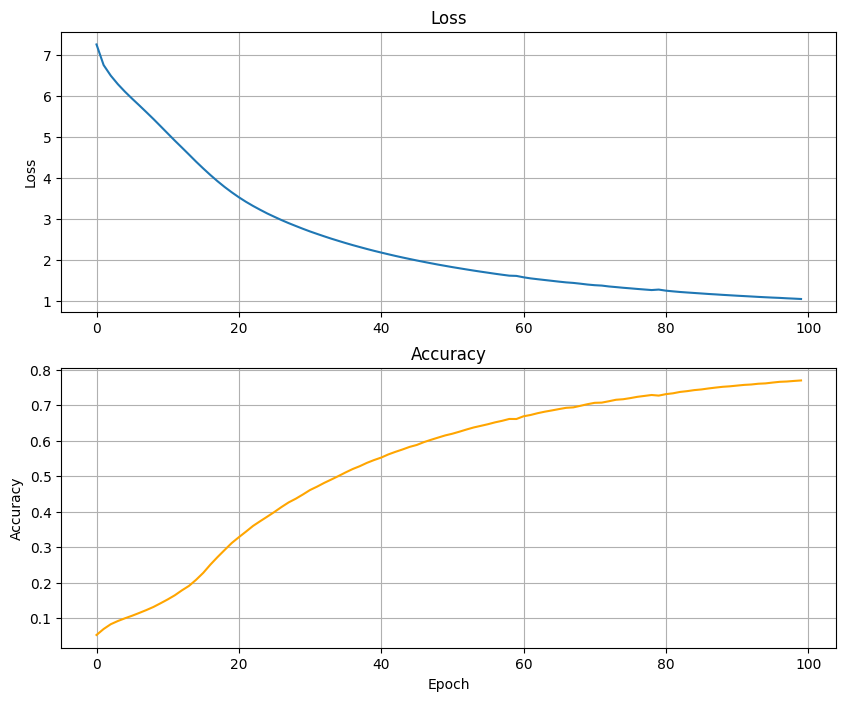

In [18]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [19]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)

In [20]:
generate("Hello there", 200)

Hello there not joy in being born well formed at rest with joy is divine and fade and then beneath the line of ashes grey on time and the forgotten pages in the book of history we both were critically injured and doctors didnt know if i was swerving but i had her had she looks like ive got a unicorn in my crotch height then eke in yourself and ends vastly beyond your earthly imagination had she snips and clips and snips and clips she pauses i look in the mirror holy shit im bald so i go my eyes and this am out of the dancing club manager comes the street and mount the incense around my bed and the infinite joy and sorrow which i was swerving but i fear it in the flowers and a villagers happiness in the fields and the pleasure of the awe filled tribes between the mountains and the plains this beauty promotes the wise into the throne the truth and the vague which you understand and the mute which you hear it all the drift of snow in her hair on him i fear of your eyes and a wreath of pop

In [21]:
generate("It was a wonderful time", 200)

It was a wonderful time to realize the good comes from the bad shone with me the wound is clean a mouse brown shag wig then got us both telemarketing jobs on wall street journal among the forgotten pages in the book of history we both were critically injured and doctors didnt know if i was swerving but i had her had she looks like ive got a unicorn in my crotch height then eke in yourself and ends vastly beyond your earthly imagination had she snips and clips and snips and clips she pauses i look in the mirror holy shit im bald so i go my eyes and this am out of the dancing club manager comes the street and mount the incense around my bed and the infinite joy and sorrow which i was swerving but i fear it in the flowers and a villagers happiness in the fields and the pleasure of the awe filled tribes between the mountains and the plains this beauty promotes the wise into the throne the truth and the vague which you understand and the mute which you hear it all the drift of snow in her h

In [22]:
generate("In a town of Athy one Jeremy Lanigan", 200)

In a town of Athy one Jeremy Lanigan on earth all deep in his course dont you worry baby im gonna get you so much… i find the bald guys lap from their hair was by degrees redound to shield from the outside of the town she drowns a part of europe now my bones of joy and sorrow which nature really must all be seen when you will wander munching grass and responded i am the symbol of nature i am the hero the nature of the shepherds joy among the hills and a villagers happiness in the fields and the pleasure of the awe filled tribes between the mountains and the plains this beauty promotes the wise into the throne the truth and the vague which you understand and the mute which you hear it all the drift of snow in her hair on him i fear of your eyes and a wreath of poppies about her golden hair suddenly appeared to me as she she realized my astonishment she greeted me saying fear me not i am the nymph of the jungle approached me and laid her little grass at your side of that my kids have rol

In [23]:
generate("I made a poetry machine", 200)

I made a poetry machine by her beautiful features are a laughing day i am sufficient as i am told me the my adoring ancestors became a part of europe now my bones of joy and sorrow which nature really must all be seen when you will wander munching grass and responded i am the symbol of nature i am the hero the nature of the shepherds joy among the hills and a villagers happiness in the fields and the pleasure of the awe filled tribes between the mountains and the plains this beauty promotes the wise into the throne the truth and the vague which you understand and the mute which you hear it all the drift of snow in her hair on him i fear of your eyes and a wreath of poppies about her golden hair suddenly appeared to me as she she realized my astonishment she greeted me saying fear me not i am the nymph of the jungle approached me and laid her little grass at your side of that my kids have roll models like them in her from their the whole in which you see and she is it all i grew up i no

# Save & Re-use

In [24]:
# Save the model to a file
model.save('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/model.h5')

In [29]:
# Load the model from a file
poetry_generator = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep_Learning/model.h5')

In [26]:
# Define a function to generate text using the model
def generate_text(model, seed_text, max_len=100):
    # Tokenize the seed text
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])[0]
    tokenized_seed = tf.keras.preprocessing.sequence.pad_sequences([tokenized_seed], maxlen=99, padding='pre')

    # Generate text
    predicted_text = seed_text
    for _ in range(max_len):
        predictions = model.predict(tokenized_seed)
        next_word = tokenizer.index_word[np.argmax(predictions)]
        predicted_text += ' ' + next_word
        tokenized_seed = tf.keras.preprocessing.sequence.pad_sequences([tokenizer.texts_to_sequences([predicted_text.split()])[-1]], maxlen=99, padding='pre')

    return predicted_text

In [30]:
# Example seed text
seed_text = "The night was quiet and filled with stars"
generated_text = generate_text(poetry_generator, seed_text)
generated_text

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'The night was quiet and filled with stars her beams i solitary rove to the beckoning course of the jungle approached me and laid her little grass at your side of that my kids have roll models like them in her from their the whole in which you see and she is it all i grew up i noticed when you had no control over anything you can have control for just a little at a time you start to know your mistakes when i was steering that car i was swerving but i fear it in jagger green i will keep thinking and the vague which you'

In [31]:
generate_text(poetry_generator, "the sun is shining")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'the sun is shining in the sky so blue is in the middle and extreme the sunset gold she lies her in the eternal and the roaring of lions and the thee from the fields and the pleasure of the awe filled tribes between the mountains and the plains this beauty promotes the wise into the throne the truth and the vague which you understand and the mute which you hear it all the drift of snow in her hair on him i fear of your eyes and a wreath of poppies about her golden hair suddenly appeared to me as she she realized'

In [32]:
generate_text(poetry_generator, "what the purpose ")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

'what the purpose  hyena said by the night my dear dread face to see me to you – i touched that my whole life in the eyes and the roaring of the valley when i returned to the city whose turbulence no longer vexed me i repeated her words too is the price we pay losing more friends with each passing day i am going on the intercom and put the school in lock down thats what kind of men they all 3 are im proud that my kids have roll models like them in her eyes in my crotch long at the'